**Install Pyspark**

In [2]:
!pip install pyspark

  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=21d2c63b699b95bf9b09054b032019458af42929e211070ba1cf89247affd997
  Stored in directory: /Users/thainguyenvu/Library/Caches/pip/wheels/b1/91/5f/283b53010a8016a4ff1c4a1edd99bbe73afacb099645b5471b
Successfully built pyspark


**Import Library**

In [1]:
import pyspark

from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, LinearSVC, NaiveBayes, RandomForestClassifier, GBTClassifier
from pyspark.ml.linalg import Vectors


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import col
from pyspark.sql.functions import rand

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from xgboost.spark import SparkXGBClassifier
import time

spark = SparkSession.builder \
    .appName("RandomOversamplingFraudDetection") \
    .master("local[4]") \
    .config("spark.executor.memory", "7g") \
    .config("spark.driver.memory", "7g") \
    .config("spark.rpc.message.maxSize", "2047") \
    .config("spark.memory.offHeap.size", "16g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/01 20:36:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read data from csv file /Users/thainguyenvu/Downloads
df = pd.read_csv("/Users/thainguyenvu/Downloads/PS_20174392719_1491204439457_log.csv")

In [3]:
# Start exploring the dataset
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [4]:
# Print the shape of the data
data = df.sample(frac=0.1, random_state = 1)
print(data.shape)
print(data.describe())

(636262, 11)
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  636262.000000  6.362620e+05   6.362620e+05    6.362620e+05   
mean      243.095005  1.797005e+05   8.366566e+05    8.579998e+05   
std       142.521600  5.913780e+05   2.892569e+06    2.928367e+06   
min         1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%       155.000000  1.338487e+04   0.000000e+00    0.000000e+00   
50%       238.000000  7.527145e+04   1.416326e+04    0.000000e+00   
75%       335.000000  2.090753e+05   1.074859e+05    1.448757e+05   
max       742.000000  6.750076e+07   5.731626e+07    4.731626e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    6.362620e+05    6.362620e+05  636262.000000        636262.0  
mean     1.096128e+06    1.220355e+06       0.001287             0.0  
std      3.303671e+06    3.578730e+06       0.035855             0.0  
min      0.000000e+00    0.000000e+00       0.000000             0.0  
25%      0

In [10]:
# Number of value each class isFraud
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [11]:
print(df['isFraud'].value_counts())
print('\n')
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    6354407
1       8213
Name: count, dtype: int64


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [12]:
# Remove duplicate data
print("Duplicate vs Non duplicate counts :")
print(df.duplicated().value_counts())

Duplicate vs Non duplicate counts :
False    6362620
Name: count, dtype: int64


In [ ]:
classes=df['isFraud'].value_counts()
Valid=round(classes[0]/df['isFraud'].count(), 4)
Fraud=round(classes[1]/df['isFraud'].count(), 4)

print('Giao dịch gian lận (Nhãn 1): {0} % ({1})'.format(Fraud, classes[1]))
print('Giao dịch không gian lận (Nhãn 0) : {0} % ({1})'.format(Valid, classes[0]))

Giao dịch gian lận (Nhãn 1): 0.0013 % (8213)
Giao dịch không gian lận (Nhãn 0) : 0.9987 % (6354407)


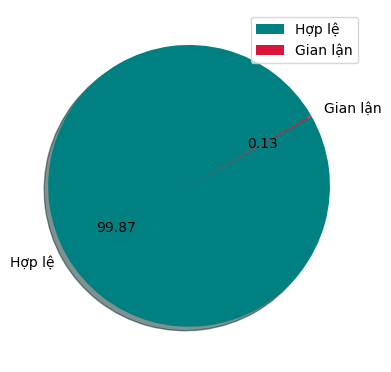

In [ ]:
# Tạo biểu đồ cho số lượng và tỷ lệ phần trăm giao dịch gian lận so với Giao dịch hợp lệ
plt.figure(figsize=(10,5))

plt.subplot(122)
plt.pie(x=[Valid,Fraud],labels=['Hợp lệ','Gian lận'],
        autopct='%.2f', colors=['#008080','crimson'], startangle=30, shadow=True)
plt.legend(loc='best')

plt.show()

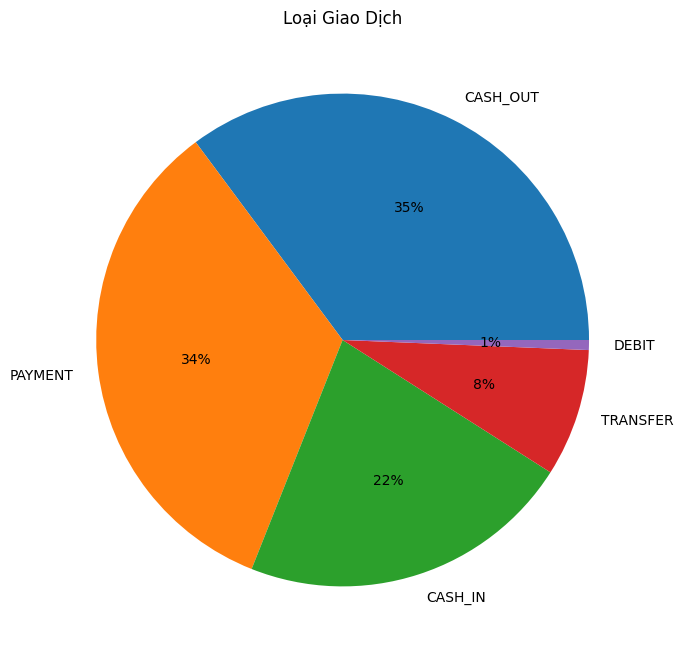

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Loại Giao Dịch")
plt.show()

**Calculation confuse matrix**

In [2]:
def confusion_matrix(predictions, label_col="isFraud", prediction_col="prediction"):
    # Let's start by creating a DataFrame containing label and prediction
    df_confusion = predictions.select(label_col, prediction_col)

    # Now, let's crunch the numbers and compute the confusion matrix by grouping predictions by label and prediction
    confusion_matrix = df_confusion.groupBy(label_col) \
        .pivot(prediction_col, [str(i) for i in range(2)]) \
        .count() \
        .na.fill(0)

    # And finally, let's unveil the confusion matrix for all to see
    confusion_matrix.show()

**Evaluate model function**

In [21]:
def compute_metrics(predictions):
     # Let's start by evaluating the model with BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

    # First, let's check out the AUC-ROC
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

    # Extract values from the confusion matrix DataFrame
    TP = predictions.filter((col('isFraud') == 1) & (col('prediction') == 1)).count()
    TN = predictions.filter((col('isFraud') == 0) & (col('prediction') == 0)).count()
    FP = predictions.filter((col('isFraud') == 0) & (col('prediction') == 1)).count()
    FN = predictions.filter((col('isFraud') == 1) & (col('prediction') == 0)).count()

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Compute precision
    precision = TP / (TP + FP)

    # Compute recall
    recall = TP / (TP + FN)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return auc_roc, accuracy, precision, recall, f1_score

**Read data using pyspark**

In [2]:
# Read data from csv file
df = spark.read.csv("/Users/thainguyenvu/Downloads/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

**Convert type string to numerical format**

In [3]:
# Create a StringIndexer to convert the 'type' column to numerical format
string_indexer = StringIndexer(inputCol="type", outputCol="type_index")

# Train the StringIndexer on the data
string_indexer_model = string_indexer.fit(df)

# Apply the StringIndexer to transform the data
indexed_data = string_indexer_model.transform(df)

# Display the results
indexed_data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|       0.0|
|   1|

**Select and define feature columns that using to train model**

In [4]:
# Define feature columns
feature_cols = ['type_index', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_new = assembler.transform(indexed_data)
df_new.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|       1.0|[1.0,9839.64,1701...|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|       1.0|[1.0,1864.28,2124...|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|       3.0|[3.0,181.0,181.0,...|
|   1|CASH_OUT|   181.

**Split data to 20% to test and 80% to train model**

In [5]:
train_df, test_df = df_new.randomSplit([0.8, 0.2], seed=123)

# Display number of rows data each train, test data
print("Number of rows in train dataset:", train_df.count())
print("Number of rows in test dataset:", test_df.count())

Number of rows in train dataset: 5089005


Number of rows in test dataset: 1273615


In [6]:
df.unpersist()
del df
indexed_data.unpersist()
del indexed_data
df_new.unpersist()
del df_new

In [6]:
train_df.cache()
test_df.cache()

DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int, isFlaggedFraud: int, type_index: double, features: vector]

**Count number of fraud and not fraud in train dataset**

In [8]:
train_df.groupBy("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   6610|
|      0|5082390|
+-------+-------+



# **TRAINNING MODEL**

**Define an array to save the value evaluation on the test data**

In [8]:
model_accuracy = []
model_precision = []
model_recall = []
model_f1 = []

**Define an array to save the value evaluation on the train data**

In [9]:
model_accuracy_train = []
model_precision_train = []
model_recall_train = []
model_f1_train = []

In [11]:
 train_df.rdd.getNumPartitions()

8

In [11]:
train_df.repartition(100)

DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int, isFlaggedFraud: int, type_index: double, features: vector]

In [12]:
 train_df.rdd.getNumPartitions()

8

**Traning model using Decision Tree Classifier**
- Using three parameters:
    + maxDepth in [5, 10, 15]
    + maxBins in [20, 40, 60]
    + impurity in ["gini", "entropy"]
- Using 10-fold to cross validation

In [10]:
# Build model using Decision Tree
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [20, 30]) \
    .addGrid(dt.maxBins, [500, 1000]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())
print("Best Impurity:", best_model._java_obj.getImpurity())

Best Max Depth: 20
Best Max Bins: 1000
Best Impurity: gini


In [11]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9855793257521246
Accuracy: 0.9996718016362809
Precision: 0.9211087420042644
Recall: 0.8084840923268871
F1-score: 0.8611295681063124


In [12]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9983396470270001
Accuracy: 0.9998023187266654
Precision: 0.9839378238341969
Recall: 0.861875945537065
F1-score: 0.9188709677419354


**Traning model using Support Vector Machine**
- Using two parameters:
  + maxIter in [10, 100]
  + regParam in [0.1, 0.01]
- Using 10-fold to cross validation

In [13]:
# Build model Support Vector Machine
svm = LinearSVC(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

24/06/11 15:31:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/11 15:31:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Best Max Iterations: 100


In [14]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9473758705474362
Accuracy: 0.9991174761702862
Precision: 0.9818913480885312
Recall: 0.30442919525888956
F1-score: 0.4647619047619047


In [15]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9463431640299524
Accuracy: 0.9990803694242484
Precision: 0.9849246231155779
Recall: 0.29652042360060515
F1-score: 0.4558139534883721


**Traning model using Naive Bayes**
- Using two parameters:
  + smoothing in [0.1, 0.5, 1.0]
- Using 10-fold to cross validation

In [16]:
# Build model Naive Bayes
nb = NaiveBayes(labelCol="isFraud", featuresCol="features")

# Define parameter grid (smoothing parameter)
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.1, 0.5, 1.0]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Smoothing Parameter:", best_model._java_obj.getSmoothing())

Best Smoothing Parameter: 0.1


In [17]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.43775937418798766
Accuracy: 0.6257290243557733
Precision: 0.002879697296935299
Recall: 0.8583905177791641
F1-score: 0.005740137788336591


In [18]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.4425467444871547
Accuracy: 0.625080762428768
Precision: 0.0029670037810345983
Recall: 0.8585476550680786
F1-score: 0.005913571203044421


**Traning model using Logistic Regression**
- Using two parameters:
  + regParam in [0.1, 0.01]
  + elasticNetParam in [0.0, 0.5, 1.0]
  + maxIter in [10, 100]
- Using 10-fold to cross validation

In [19]:
# Build model Logistic Regression
lr = LogisticRegression(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 100]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Elastic Net Parameter:", best_model._java_obj.getElasticNetParam())
print("Best Max Iterations:", best_model._java_obj.getMaxIter())

Best Elastic Net Parameter: 1.0
Best Max Iterations: 100


In [20]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.973639534387689
Accuracy: 0.9992273990672257
Precision: 0.8529076396807298
Recall: 0.46662507797878977
F1-score: 0.603225806451613


In [21]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

AUC ROC: 0.9715343374596548
Accuracy: 0.9992020043230497
Precision: 0.8623827125390958
Recall: 0.4588502269288956
F1-score: 0.5989927915473487


**Traning model using Random Forest**
- Using two parameters:
  + MaxDepth in [20, 30]
  + maxDepth in [500, 1000]
- Using 10-fold to cross validation

In [22]:
# Build model Random Forest
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [20, 30]) \
    .addGrid(rf.maxBins, [500, 1000]) \
    .build()


# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

24/06/11 16:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1225.1 KiB
24/06/11 16:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1549.6 KiB
24/06/11 16:06:01 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB
24/06/11 16:06:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 16:06:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 16:06:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 16:06:11 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 16:06:13 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 16:06:19 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 16:06:45 WARN DAGScheduler: Broadcasting large task binary with size 1200.8 KiB
24/06/11 16:06:48 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB
24/06/11 16:06:50 WARN DAGScheduler: Br

24/06/11 16:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1706.4 KiB
24/06/11 16:38:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 16:38:56 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 16:38:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 16:39:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 16:39:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 16:39:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 16:39:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 16:39:12 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 16:39:15 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 16:39:18 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/06/11 16:39:20 WARN DAGScheduler: Broadcasting l

24/06/11 17:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1394.8 KiB
24/06/11 17:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1709.2 KiB
24/06/11 17:21:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 17:22:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 17:22:02 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 17:22:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 17:22:08 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 17:22:11 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 17:22:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 17:22:16 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 17:22:19 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 17:22:21 WARN DAGScheduler: Broadcastin

24/06/11 17:59:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/06/11 17:59:07 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/06/11 17:59:09 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/06/11 17:59:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 17:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1164.8 KiB
24/06/11 17:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1480.0 KiB
24/06/11 17:59:56 WARN DAGScheduler: Broadcasting large task binary with size 1866.5 KiB
24/06/11 17:59:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 18:00:03 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 18:00:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 18:00:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 18:00:12 WARN DAGScheduler: Broadcas

Best Max Depth: 20
Best Max Bins: 500


In [23]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/11 18:00:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:00:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:00:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:00:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


AUC ROC: 0.9995455657943765
Accuracy: 0.9996694461456321
Precision: 0.96171875
Recall: 0.767935121646912
F1-score: 0.8539715574054805


In [24]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/11 18:01:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:01:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:01:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:01:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


AUC ROC: 0.9999675986745478
Accuracy: 0.9997836510119866
Precision: 0.988126882863725
Recall: 0.84357034795764
F1-score: 0.9101444544193259


**Traning model using Gradient Boosting Trees**
- Using three parameters:
  + maxDepth in [20, 30]
  + maxBins in [500, 1000]
- Using 10-fold to cross validation

In [25]:
# Build model Gradient Boosting Tree
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [20, 30]) \
    .addGrid(gbt.maxBins, [500, 1000]) \
    .build()

# Create CrossValidator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='isFraud', metricName='areaUnderROC')

# Use CrossValidator to select the best model
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

# Train model
cv_model = crossval.fit(train_df)

# Best model
best_model = cv_model.bestModel

# Display best parameters
print("Best Max Depth:", best_model._java_obj.getMaxDepth())
print("Best Max Bins:", best_model._java_obj.getMaxBins())

24/06/11 18:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1049.9 KiB
24/06/11 18:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1120.6 KiB
24/06/11 18:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB
24/06/11 18:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1022.0 KiB
24/06/11 18:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
24/06/11 18:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1023.8 KiB
24/06/11 18:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1025.6 KiB
24/06/11 18:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1028.7 KiB
24/06/11 18:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1032.0 KiB
24/06/11 18:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
24/06/11 18:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
24/06/11 18:01:56 WAR

24/06/11 18:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 18:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 18:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 18:02:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 18:02:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 18:02:19 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 18:02:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 18:02:20 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:02:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 18:02:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:02:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 18:02:22 WARN DAGScheduler: Broadcasting larg

24/06/11 18:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 18:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 18:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 18:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 18:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 18:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 18:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 18:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 18:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 18:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 18:02:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 18:02:50 WARN DAGScheduler: Broadcasting larg

24/06/11 18:03:22 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:22 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:23 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:23 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:23 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 18:03:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 18:03:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 18:03:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 18:03:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 18:03:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 18:03:26 WARN DAGScheduler: Broadcasting larg

24/06/11 20:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1741.6 KiB
24/06/11 20:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1755.2 KiB
24/06/11 20:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1772.5 KiB
24/06/11 20:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1797.6 KiB
24/06/11 20:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1833.2 KiB
24/06/11 20:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1879.0 KiB
24/06/11 20:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1934.5 KiB
24/06/11 20:00:50 WARN DAGScheduler: Broadcasting large task binary with size 2000.5 KiB
24/06/11 20:00:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1978.5 KiB
24/06/11 20:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1979.0 KiB
24/06/11 20:00:51 WARN D

24/06/11 20:02:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:02:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:02:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:02:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:02:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:02:50 WARN DAGScheduler: Broadcasting larg

24/06/11 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:24 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:24 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:24 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:03:25 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:03:25 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:03:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:03:26 WARN DAGScheduler: Broadcasting larg

24/06/11 20:04:18 WARN DAGScheduler: Broadcasting large task binary with size 1604.3 KiB
24/06/11 20:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
24/06/11 20:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1641.5 KiB
24/06/11 20:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1653.3 KiB
24/06/11 20:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1659.7 KiB
24/06/11 20:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1433.9 KiB
24/06/11 20:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1434.4 KiB
24/06/11 20:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1435.0 KiB
24/06/11 20:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1436.2 KiB
24/06/11 20:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1437.9 KiB
24/06/11 20:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1441.0 KiB
24/06/11 20:04:22 WAR

24/06/11 20:04:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:04:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:04:55 WARN DAGScheduler: Broadcasting larg

24/06/11 20:05:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:05:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:05:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:05:28 WARN DAGScheduler: Broadcasting larg

24/06/11 20:06:00 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:06:01 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:06:01 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:06:01 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:06:02 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:06:02 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:06:02 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:06:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:06:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:06:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:06:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:06:05 WARN DAGScheduler: Broadcasting larg

24/06/11 20:07:36 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/06/11 20:07:37 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/06/11 20:07:37 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/06/11 20:07:38 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/06/11 20:07:39 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/06/11 20:07:40 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/11 20:07:40 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/11 20:07:41 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/11 20:07:41 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/06/11 20:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1023.3 KiB
24/06/11 20:08:28 WARN DAGScheduler: Broadcasting large task binary with size 1054.5 KiB
24/06/11 20:08:28 WARN DAGScheduler: Broadcastin

24/06/11 20:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1947.8 KiB
24/06/11 20:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1957.0 KiB
24/06/11 20:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1787.6 KiB
24/06/11 20:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
24/06/11 20:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1788.7 KiB
24/06/11 20:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1789.8 KiB
24/06/11 20:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1791.8 KiB
24/06/11 20:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1794.6 KiB
24/06/11 20:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1798.3 KiB
24/06/11 20:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1801.9 KiB
24/06/11 20:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1806.6 KiB
24/06/11 20:09:13 WAR

24/06/11 20:09:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 20:09:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 20:09:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:09:51 WARN DAGScheduler: Broadcasting larg

24/06/11 20:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:26 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:26 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:10:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:10:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:10:29 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:10:29 WARN DAGScheduler: Broadcasting larg

24/06/11 20:11:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:11:04 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:11:04 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:11:05 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:11:05 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:11:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:11:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:11:07 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:11:07 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:11:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:11:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:11:09 WARN DAGScheduler: Broadcasting larg

24/06/11 20:11:45 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:11:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:11:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:11:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:11:47 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:11:47 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:11:47 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:11:48 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:11:49 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:11:49 WARN DAGScheduler: Broadcasting larg

24/06/11 20:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1888.8 KiB
24/06/11 20:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1893.7 KiB
24/06/11 20:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1899.6 KiB
24/06/11 20:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1906.7 KiB
24/06/11 20:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1915.3 KiB
24/06/11 20:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1926.8 KiB
24/06/11 20:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1942.5 KiB
24/06/11 20:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1967.3 KiB
24/06/11 20:13:14 WARN DAGScheduler: Broadcasting large task binary with size 2003.4 KiB
24/06/11 20:13:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:13:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 20:13:16 WARN DAGS

24/06/11 20:13:53 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:53 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:13:57 WARN DAGScheduler: Broadcasting larg

24/06/11 20:14:45 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:46 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:14:47 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:50 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:50 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:14:51 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:14:51 WARN DAGScheduler: Broadcasting larg

24/06/11 20:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1363.9 KiB
24/06/11 20:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1370.1 KiB
24/06/11 20:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1378.8 KiB
24/06/11 20:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1389.8 KiB
24/06/11 20:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1403.9 KiB
24/06/11 20:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1422.8 KiB
24/06/11 20:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1446.3 KiB
24/06/11 20:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB
24/06/11 20:16:21 WARN DAGScheduler: Broadcasting large task binary with size 1514.8 KiB
24/06/11 20:16:21 WARN DAGScheduler: Broadcasting large task binary with size 1562.3 KiB
24/06/11 20:16:22 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
24/06/11 20:16:22 WAR

24/06/11 20:17:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:17:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:17:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:17:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:17:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:17:52 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:17:52 WARN DAGScheduler: Broadcasting larg

24/06/11 20:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1076.7 KiB
24/06/11 20:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1077.3 KiB
24/06/11 20:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1078.5 KiB
24/06/11 20:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB
24/06/11 20:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1083.4 KiB
24/06/11 20:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1086.9 KiB
24/06/11 20:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1090.7 KiB
24/06/11 20:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1095.5 KiB
24/06/11 20:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
24/06/11 20:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1107.3 KiB
24/06/11 20:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1114.6 KiB
24/06/11 20:19:09 WAR

24/06/11 20:19:41 WARN DAGScheduler: Broadcasting large task binary with size 2020.9 KiB
24/06/11 20:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2023.5 KiB
24/06/11 20:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2026.6 KiB
24/06/11 20:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2030.6 KiB
24/06/11 20:19:43 WARN DAGScheduler: Broadcasting large task binary with size 2035.7 KiB
24/06/11 20:19:43 WARN DAGScheduler: Broadcasting large task binary with size 2042.9 KiB
24/06/11 20:19:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:19:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:19:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:19:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:19:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 20:19:45 WARN DAGScheduler:

24/06/11 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:20:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:20:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:20:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:20:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 20:20:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 20:20:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 20:20:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 20:20:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 20:20:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 20:20:26 WARN DAGScheduler: Broadcasting larg

24/06/11 20:21:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 20:21:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 20:21:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 20:21:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 20:21:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 20:21:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 20:21:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:21:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:21:05 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:21:05 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:21:06 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:21:06 WARN DAGScheduler: Broadcasting larg

24/06/11 20:21:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:21:44 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:21:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:21:45 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:21:45 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:21:46 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:21:46 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:21:46 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:21:47 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:21:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:21:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:21:49 WARN DAGScheduler: Broadcasting larg

24/06/11 20:22:23 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:22:23 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:22:23 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:25 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:26 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:26 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:27 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:22:27 WARN DAGScheduler: Broadcasting larg

24/06/11 20:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1534.2 KiB
24/06/11 20:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1536.7 KiB
24/06/11 20:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1539.5 KiB
24/06/11 20:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1542.9 KiB
24/06/11 20:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1546.8 KiB
24/06/11 20:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1552.9 KiB
24/06/11 20:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1560.8 KiB
24/06/11 20:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1569.1 KiB
24/06/11 20:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1577.0 KiB
24/06/11 20:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1585.5 KiB
24/06/11 20:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1595.7 KiB
24/06/11 20:23:28 WAR

24/06/11 20:23:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:23:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:23:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:23:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:23:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:24:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:24:00 WARN DAGScheduler: Broadcasting larg

24/06/11 20:24:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:24:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:24:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:24:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:24:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:24:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:24:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:24:33 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:24:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:24:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:24:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:24:34 WARN DAGScheduler: Broadcasting larg

24/06/11 20:25:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:25:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:25:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:25:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:25:58 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:25:58 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:25:59 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 20:25:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:25:59 WARN DAGScheduler: Broadcasting larg

24/06/11 20:26:55 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:26:55 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:26:56 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:26:56 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:26:56 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:57 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:59 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 20:26:59 WARN DAGScheduler: Broadcasting larg

24/06/11 20:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1403.7 KiB
24/06/11 20:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1406.8 KiB
24/06/11 20:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1411.9 KiB
24/06/11 20:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1418.0 KiB
24/06/11 20:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1425.0 KiB
24/06/11 20:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1434.1 KiB
24/06/11 20:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1446.6 KiB
24/06/11 20:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1463.6 KiB
24/06/11 20:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1486.3 KiB
24/06/11 20:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1517.8 KiB
24/06/11 20:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1558.9 KiB
24/06/11 20:28:03 WAR

24/06/11 20:28:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 20:28:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:52 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:53 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:53 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:28:54 WARN DAGScheduler: Broadcasting larg

24/06/11 20:29:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:29:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:29:36 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:29:37 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:29:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:39 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:39 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:40 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:40 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:41 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:29:41 WARN DAGScheduler: Broadcasting larg

24/06/11 20:30:29 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 20:30:30 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 20:30:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:30:31 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:30:31 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:30:32 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/06/11 20:30:33 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/06/11 20:30:35 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/06/11 20:30:37 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/06/11 20:30:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
24/06/11 20:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
24/06/11 20:31:44 WARN DAGScheduler: Broadcasting l

24/06/11 20:32:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 20:32:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:32:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:32:37 WARN DAGScheduler: Broadcasting larg

24/06/11 20:33:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 20:33:30 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 20:33:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 20:33:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 20:33:38 WARN DAGScheduler: Broadcasting larg

24/06/11 20:34:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 20:34:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 20:34:35 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:34:35 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:34:36 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 20:34:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 20:34:38 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:34:40 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/06/11 20:34:41 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:34:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:34:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 20:34:44 WARN DAGScheduler: Broadcasting larg

24/06/11 20:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1885.7 KiB
24/06/11 20:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1915.4 KiB
24/06/11 20:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB
24/06/11 20:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1952.7 KiB
24/06/11 20:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1962.8 KiB
24/06/11 20:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1969.1 KiB
24/06/11 20:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1971.9 KiB
24/06/11 20:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1742.6 KiB
24/06/11 20:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1743.0 KiB
24/06/11 20:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1743.6 KiB
24/06/11 20:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1744.8 KiB
24/06/11 20:36:05 WAR

24/06/11 20:36:41 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:36:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:36:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:44 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:44 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:36:46 WARN DAGScheduler: Broadcasting larg

24/06/11 20:37:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:26 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:26 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:27 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:37:27 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:37:27 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:37:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:37:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:37:29 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:37:29 WARN DAGScheduler: Broadcasting larg

24/06/11 20:38:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:38:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:38:11 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:38:11 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:38:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:38:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:38:13 WARN DAGScheduler: Broadcasting larg

24/06/11 20:38:55 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:38:56 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:38:56 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 20:38:57 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 20:38:58 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 20:38:58 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 20:38:59 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 20:38:59 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:39:00 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:39:01 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:39:01 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 20:39:02 WARN DAGScheduler: Broadcasting larg

24/06/11 20:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1357.2 KiB
24/06/11 20:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1374.0 KiB
24/06/11 20:40:41 WARN DAGScheduler: Broadcasting large task binary with size 1386.0 KiB
24/06/11 20:40:42 WARN DAGScheduler: Broadcasting large task binary with size 1214.1 KiB
24/06/11 20:40:42 WARN DAGScheduler: Broadcasting large task binary with size 1214.5 KiB
24/06/11 20:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
24/06/11 20:40:43 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB
24/06/11 20:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1218.1 KiB
24/06/11 20:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1221.2 KiB
24/06/11 20:40:45 WARN DAGScheduler: Broadcasting large task binary with size 1224.5 KiB
24/06/11 20:40:45 WARN DAGScheduler: Broadcasting large task binary with size 1228.0 KiB
24/06/11 20:40:45 WAR

24/06/11 20:41:23 WARN DAGScheduler: Broadcasting large task binary with size 2015.8 KiB
24/06/11 20:41:25 WARN DAGScheduler: Broadcasting large task binary with size 2016.3 KiB
24/06/11 20:41:25 WARN DAGScheduler: Broadcasting large task binary with size 2016.9 KiB
24/06/11 20:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2018.1 KiB
24/06/11 20:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2019.8 KiB
24/06/11 20:41:26 WARN DAGScheduler: Broadcasting large task binary with size 2022.4 KiB
24/06/11 20:41:27 WARN DAGScheduler: Broadcasting large task binary with size 2025.5 KiB
24/06/11 20:41:27 WARN DAGScheduler: Broadcasting large task binary with size 2029.2 KiB
24/06/11 20:41:28 WARN DAGScheduler: Broadcasting large task binary with size 2034.4 KiB
24/06/11 20:41:28 WARN DAGScheduler: Broadcasting large task binary with size 2039.9 KiB
24/06/11 20:41:29 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB
24/06/11 20:41:29 WAR

24/06/11 20:42:08 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:09 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:09 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:42:13 WARN DAGScheduler: Broadcasting larg

24/06/11 20:42:54 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:42:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:42:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:42:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:42:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:42:59 WARN DAGScheduler: Broadcasting larg

24/06/11 20:43:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:43:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:43:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:43:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:43:44 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:43:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:43:45 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:43:46 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:43:46 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:43:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:43:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:43:48 WARN DAGScheduler: Broadcasting larg

24/06/11 20:44:33 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:44:33 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:44:34 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:44:35 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:44:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:44:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:44:36 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:44:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB
24/06/11 20:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1087.3 KiB
24/06/11 20:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/06/11 20:45:28 WARN DAGScheduler: Broadcas

24/06/11 20:46:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:46:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 20:46:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:46:58 WARN DAGScheduler: Broadcasting larg

24/06/11 20:47:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:47:43 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:47:44 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:47:44 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:47:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:47:45 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:47:46 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:47:48 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:47:48 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:47:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 20:47:49 WARN DAGScheduler: Broadcasting larg

24/06/11 20:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1922.7 KiB
24/06/11 20:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1923.9 KiB
24/06/11 20:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1925.8 KiB
24/06/11 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1928.2 KiB
24/06/11 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1931.2 KiB
24/06/11 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1934.7 KiB
24/06/11 20:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1940.0 KiB
24/06/11 20:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1945.9 KiB
24/06/11 20:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1953.8 KiB
24/06/11 20:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1963.7 KiB
24/06/11 20:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1976.3 KiB
24/06/11 20:49:17 WAR

24/06/11 20:49:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 20:49:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:49:55 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:49:59 WARN DAGScheduler: Broadcasting larg

24/06/11 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:50:39 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:50:40 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:50:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:50:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 20:50:42 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 20:50:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 20:50:43 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 20:50:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 20:50:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 20:50:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 20:50:45 WARN DAGScheduler: Broadcasting larg

24/06/11 20:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1400.6 KiB
24/06/11 20:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1404.8 KiB
24/06/11 20:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1408.8 KiB
24/06/11 20:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1413.7 KiB
24/06/11 20:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1419.8 KiB
24/06/11 20:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1427.8 KiB
24/06/11 20:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1437.4 KiB
24/06/11 20:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1448.2 KiB
24/06/11 20:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1461.4 KiB
24/06/11 20:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
24/06/11 20:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1505.2 KiB
24/06/11 20:51:55 WAR

24/06/11 20:52:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:52:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:52:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:52:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:52:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 20:52:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:52:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:52:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:52:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 20:52:29 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 20:52:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 20:52:30 WARN DAGScheduler: Broadcasting larg

24/06/11 20:53:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:53:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:53:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 20:53:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 20:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:53:06 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:53:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:53:07 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:53:07 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:53:07 WARN DAGScheduler: Broadcasting larg

24/06/11 20:53:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:53:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:53:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:53:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:53:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:53:45 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 20:53:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:53:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:53:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:53:47 WARN DAGScheduler: Broadcasting larg

24/06/11 20:54:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:54:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 20:54:23 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:23 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:24 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:24 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:25 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:25 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:25 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:26 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:26 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 20:54:27 WARN DAGScheduler: Broadcasting larg

24/06/11 20:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1109.4 KiB
24/06/11 20:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
24/06/11 20:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1142.1 KiB
24/06/11 20:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB
24/06/11 20:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
24/06/11 20:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1010.4 KiB
24/06/11 20:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1019.9 KiB
24/06/11 20:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
24/06/11 20:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1047.4 KiB
24/06/11 20:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1067.0 KiB
24/06/11 20:55:41 WARN DAGScheduler: Broadcasting large task binary with size 1090.3 KiB
24/06/11 20:55:41 WAR

24/06/11 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1810.1 KiB
24/06/11 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1817.0 KiB
24/06/11 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1825.5 KiB
24/06/11 20:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1834.9 KiB
24/06/11 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1846.2 KiB
24/06/11 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1861.3 KiB
24/06/11 20:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1879.3 KiB
24/06/11 20:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1901.1 KiB
24/06/11 20:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1924.7 KiB
24/06/11 20:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1952.4 KiB
24/06/11 20:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1983.7 KiB
24/06/11 20:56:15 WAR

24/06/11 20:56:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:56:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:56:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 20:56:48 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 20:56:48 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 20:56:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 20:56:49 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:56:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:56:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 20:56:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:56:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 20:56:51 WARN DAGScheduler: Broadcasting larg

24/06/11 20:57:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 20:57:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:57:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:57:37 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:57:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:57:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:57:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 20:57:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:57:40 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 20:57:41 WARN DAGScheduler: Broadcasting larg

24/06/11 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 20:58:19 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:22 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 20:58:23 WARN DAGScheduler: Broadcasting larg

24/06/11 20:59:00 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:59:01 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 20:59:01 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:02 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:02 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:02 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:04 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:04 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:04 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 20:59:05 WARN DAGScheduler: Broadcasting larg

24/06/11 21:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1932.9 KiB
24/06/11 21:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1934.1 KiB
24/06/11 21:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1935.9 KiB
24/06/11 21:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1938.7 KiB
24/06/11 21:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1942.1 KiB
24/06/11 21:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1946.8 KiB
24/06/11 21:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1952.6 KiB
24/06/11 21:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
24/06/11 21:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1970.4 KiB
24/06/11 21:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1981.6 KiB
24/06/11 21:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1995.8 KiB
24/06/11 21:00:15 WAR

24/06/11 21:00:50 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:00:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:00:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:53 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:53 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:56 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:00:56 WARN DAGScheduler: Broadcasting larg

24/06/11 21:01:33 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:01:34 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:01:34 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:01:35 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 21:01:35 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:01:39 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:01:39 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:01:40 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:01:40 WARN DAGScheduler: Broadcasting larg

24/06/11 21:04:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:04:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:04:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:04:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:04:20 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:04:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:23 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:04:24 WARN DAGScheduler: Broadcasting larg

24/06/11 21:05:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:05:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:05:17 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:05:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:05:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:05:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:05:19 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:05:20 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:05:21 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:05:22 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:05:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 21:05:24 WARN DAGScheduler: Broadcasting larg

24/06/11 21:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1175.6 KiB
24/06/11 21:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1212.8 KiB
24/06/11 21:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB
24/06/11 21:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1269.8 KiB
24/06/11 21:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1287.2 KiB
24/06/11 21:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1300.3 KiB
24/06/11 21:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1308.6 KiB
24/06/11 21:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1312.5 KiB
24/06/11 21:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB
24/06/11 21:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1081.3 KiB
24/06/11 21:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1081.9 KiB
24/06/11 21:06:57 WAR

24/06/11 21:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:07:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:07:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:07:29 WARN DAGScheduler: Broadcasting large task binary with size 2021.8 KiB
24/06/11 21:07:30 WARN DAGScheduler: Broadcasting large task binary with size 2022.3 KiB
24/06/11 21:07:31 WARN DAGScheduler: Broadcasting large task binary with size 2022.9 KiB
24/06/11 21:07:31 WARN DAGScheduler: Broadcasting large task binary with size 2024.1 KiB
24/06/11 21:07:32 WARN DAGScheduler: Broadcasting large task binary with size 2026.1 KiB
24/06/11 21:07:32 WARN DAGScheduler: Broadcasting large task binary with size 2028.4 KiB
24/06/11 21:07:32 WARN DAGScheduler:

24/06/11 21:08:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:08:08 WARN DAGScheduler: Broadcasting larg

24/06/11 21:08:42 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:08:46 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:08:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:08:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:08:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:08:48 WARN DAGScheduler: Broadcasting larg

24/06/11 21:09:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 21:09:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:09:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:09:33 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:09:33 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:09:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:09:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:09:35 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:09:35 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:09:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:09:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 21:09:37 WARN DAGScheduler: Broadcasting larg

24/06/11 21:10:17 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 21:10:17 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:10:18 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:10:18 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:10:19 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 21:10:19 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 21:10:20 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 21:10:20 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 21:10:20 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 21:10:21 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 21:10:21 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 21:10:22 WARN DAGScheduler: Broadcasting larg

24/06/11 21:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1582.5 KiB
24/06/11 21:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1614.3 KiB
24/06/11 21:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1644.7 KiB
24/06/11 21:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1670.4 KiB
24/06/11 21:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1689.9 KiB
24/06/11 21:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1703.3 KiB
24/06/11 21:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1713.3 KiB
24/06/11 21:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1721.2 KiB
24/06/11 21:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1726.1 KiB
24/06/11 21:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1541.5 KiB
24/06/11 21:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1541.9 KiB
24/06/11 21:11:34 WAR

24/06/11 21:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 21:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:12:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:12:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:12:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:12:08 WARN DAGScheduler: Broadcasting larg

24/06/11 21:12:42 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:42 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:42 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:43 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:43 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:45 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:12:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 21:12:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 21:12:46 WARN DAGScheduler: Broadcasting larg

24/06/11 21:13:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:13:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:13:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:13:22 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:13:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:13:25 WARN DAGScheduler: Broadcasting larg

24/06/11 21:14:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:14:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:14:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:14:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:14:03 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:14:04 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:14:04 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:14:04 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:14:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:14:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:14:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:14:06 WARN DAGScheduler: Broadcasting larg

24/06/11 21:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1155.0 KiB
24/06/11 21:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1173.4 KiB
24/06/11 21:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1199.3 KiB
24/06/11 21:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1232.7 KiB
24/06/11 21:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1275.1 KiB
24/06/11 21:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1326.4 KiB
24/06/11 21:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1389.9 KiB
24/06/11 21:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1308.5 KiB
24/06/11 21:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1309.0 KiB
24/06/11 21:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1309.6 KiB
24/06/11 21:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB
24/06/11 21:15:28 WAR

24/06/11 21:16:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:16:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:16:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:16:04 WARN DAGScheduler: Broadcasting larg

24/06/11 21:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 21:17:22 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:17:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:17:28 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
24/06/11 21:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1057.2 KiB
24/06/11 21:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1120.1 KiB
24/06/11 21:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB
24/06/11 21:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
24/06/11 21:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1027.6 KiB
24/06/11 21:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1028.4 KiB
24/06/11 21:18:13 WARN DAGSchedul

24/06/11 21:18:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:18:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:18:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:18:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:18:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:18:52 WARN DAGScheduler: Broadcasting larg

24/06/11 21:20:20 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:20:21 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:20:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:24 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:20:24 WARN DAGScheduler: Broadcasting larg

24/06/11 21:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1912.3 KiB
24/06/11 21:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1700.4 KiB
24/06/11 21:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1700.8 KiB
24/06/11 21:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1701.5 KiB
24/06/11 21:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1702.6 KiB
24/06/11 21:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1704.9 KiB
24/06/11 21:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1708.4 KiB
24/06/11 21:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1711.7 KiB
24/06/11 21:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1715.4 KiB
24/06/11 21:21:37 WARN DAGScheduler: Broadcasting large task binary with size 1719.6 KiB
24/06/11 21:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1724.9 KiB
24/06/11 21:21:38 WAR

24/06/11 21:22:01 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:22:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:22:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:22:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:22:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:22:05 WARN DAGScheduler: Broadcasting larg

24/06/11 21:23:01 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:23:01 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:23:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:23:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:23:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:23:07 WARN DAGScheduler: Broadcasting larg

24/06/11 21:23:48 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 21:23:48 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 21:23:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 21:23:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 21:23:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:23:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:23:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:23:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:23:52 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:23:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 21:23:53 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 21:23:53 WARN DAGScheduler: Broadcasting larg

24/06/11 21:24:29 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 21:24:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:24:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:24:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 21:24:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 21:24:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 21:24:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 21:24:33 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 21:24:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:24:34 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:24:35 WARN DAGScheduler: Broadcasting larg

24/06/11 21:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1216.7 KiB
24/06/11 21:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1217.9 KiB
24/06/11 21:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1219.8 KiB
24/06/11 21:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1222.6 KiB
24/06/11 21:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
24/06/11 21:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
24/06/11 21:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1234.2 KiB
24/06/11 21:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1240.1 KiB
24/06/11 21:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1247.4 KiB
24/06/11 21:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1254.8 KiB
24/06/11 21:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1262.0 KiB
24/06/11 21:25:53 WAR

24/06/11 21:26:26 WARN DAGScheduler: Broadcasting large task binary with size 2015.2 KiB
24/06/11 21:26:26 WARN DAGScheduler: Broadcasting large task binary with size 2018.1 KiB
24/06/11 21:26:26 WARN DAGScheduler: Broadcasting large task binary with size 2021.6 KiB
24/06/11 21:26:27 WARN DAGScheduler: Broadcasting large task binary with size 2026.0 KiB
24/06/11 21:26:27 WARN DAGScheduler: Broadcasting large task binary with size 2031.3 KiB
24/06/11 21:26:28 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB
24/06/11 21:26:28 WARN DAGScheduler: Broadcasting large task binary with size 2044.5 KiB
24/06/11 21:26:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:26:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:26:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:26:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:26:30 WARN DAGSchedul

24/06/11 21:27:04 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:04 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:27:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:27:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:27:08 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:27:08 WARN DAGScheduler: Broadcasting larg

24/06/11 21:27:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:27:44 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:27:44 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:27:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 21:27:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 21:27:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 21:27:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:27:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:27:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:27:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:27:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 21:27:48 WARN DAGScheduler: Broadcasting larg

24/06/11 21:28:25 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:28:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:28:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:28:27 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 21:28:28 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 21:28:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:28:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:28:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:28:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:28:30 WARN DAGScheduler: Broadcasting larg

24/06/11 21:29:08 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 21:29:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
24/06/11 21:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1054.7 KiB
24/06/11 21:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
24/06/11 21:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1180.7 KiB
24/06/11 21:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
24/06/11 21:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1089.3 KiB
24/06/11 21:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1089.9 KiB
24/06/11 21:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB
24/06/11 21:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
24/06/11 21:29:53 WARN DAGS

24/06/11 21:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:30:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:30:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:30:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:30:29 WARN DAGScheduler: Broadcasting larg

24/06/11 21:31:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:31:07 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:31:07 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:31:08 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:31:08 WARN DAGScheduler: Broadcasting larg

24/06/11 21:31:48 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 21:31:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:50 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:50 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:51 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:51 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:52 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:52 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:31:54 WARN DAGScheduler: Broadcasting larg

24/06/11 21:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1819.1 KiB
24/06/11 21:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB
24/06/11 21:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1830.5 KiB
24/06/11 21:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1839.0 KiB
24/06/11 21:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1850.3 KiB
24/06/11 21:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1865.9 KiB
24/06/11 21:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1887.6 KiB
24/06/11 21:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1920.2 KiB
24/06/11 21:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1966.9 KiB
24/06/11 21:33:18 WARN DAGScheduler: Broadcasting large task binary with size 2026.4 KiB
24/06/11 21:33:19 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:33:19 WARN D

24/06/11 21:34:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:34:09 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:34:09 WARN DAGScheduler: Broadcasting larg

24/06/11 21:35:00 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 21:35:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 21:35:07 WARN DAGScheduler: Broadcasting larg

24/06/11 21:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1419.2 KiB
24/06/11 21:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1432.5 KiB
24/06/11 21:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1449.7 KiB
24/06/11 21:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1471.9 KiB
24/06/11 21:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1499.9 KiB
24/06/11 21:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1531.5 KiB
24/06/11 21:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1569.1 KiB
24/06/11 21:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB
24/06/11 21:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1654.7 KiB
24/06/11 21:36:28 WARN DAGScheduler: Broadcasting large task binary with size 1698.1 KiB
24/06/11 21:36:28 WARN DAGScheduler: Broadcasting large task binary with size 1742.3 KiB
24/06/11 21:36:29 WAR

24/06/11 21:37:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 21:37:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 21:37:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 21:37:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:37:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:37:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:37:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:37:13 WARN DAGScheduler: Broadcasting larg

24/06/11 21:37:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:37:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:37:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:37:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:37:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:37:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:37:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:37:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:37:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:38:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:38:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 21:38:01 WARN DAGScheduler: Broadcasting larg

24/06/11 21:38:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 21:38:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:38:51 WARN DAGScheduler: Broadcasting larg

24/06/11 21:39:38 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:39 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:39 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:40 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:40 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:41 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:41 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:43 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:43 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:39:44 WARN DAGScheduler: Broadcasting larg

24/06/11 21:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1018.2 KiB
24/06/11 21:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
24/06/11 21:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1040.1 KiB
24/06/11 21:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1055.4 KiB
24/06/11 21:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1074.0 KiB
24/06/11 21:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1096.9 KiB
24/06/11 21:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1122.9 KiB
24/06/11 21:41:17 WARN DAGScheduler: Broadcasting large task binary with size 1151.4 KiB
24/06/11 21:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1179.6 KiB
24/06/11 21:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1210.3 KiB
24/06/11 21:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB
24/06/11 21:41:19 WAR

24/06/11 21:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1879.4 KiB
24/06/11 21:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1896.9 KiB
24/06/11 21:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1918.4 KiB
24/06/11 21:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1943.6 KiB
24/06/11 21:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1971.6 KiB
24/06/11 21:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1999.7 KiB
24/06/11 21:42:00 WARN DAGScheduler: Broadcasting large task binary with size 2029.4 KiB
24/06/11 21:42:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:42:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:42:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:42:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:42:03 WARN DAGSchedul

24/06/11 21:42:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:42:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:42:45 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:42:45 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:42:46 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:42:46 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:42:47 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 21:42:47 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 21:42:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 21:42:48 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:42:49 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:42:50 WARN DAGScheduler: Broadcasting larg

24/06/11 21:43:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 21:43:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:43:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/06/11 21:43:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:52 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:52 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:43:53 WARN DAGScheduler: Broadcasting larg

24/06/11 21:46:06 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:46:07 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:46:07 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:46:08 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:09 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:11 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:11 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:13 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:14 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 21:46:15 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 21:46:16 WARN DAGScheduler: Broadcasting larg

24/06/11 21:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1906.2 KiB
24/06/11 21:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1912.3 KiB
24/06/11 21:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1920.7 KiB
24/06/11 21:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1931.8 KiB
24/06/11 21:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1943.7 KiB
24/06/11 21:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1958.6 KiB
24/06/11 21:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1979.8 KiB
24/06/11 21:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2008.6 KiB
24/06/11 21:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2045.7 KiB
24/06/11 21:48:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:48:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:48:27 WARN DAGS

24/06/11 21:49:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:19 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 21:49:19 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:49:19 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 21:49:20 WARN DAGScheduler: Broadcasting larg

24/06/11 21:50:06 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:07 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 21:50:08 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:10 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:10 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:11 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:11 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:12 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:12 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 21:50:13 WARN DAGScheduler: Broadcasting larg

24/06/11 21:52:21 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB
24/06/11 21:52:21 WARN DAGScheduler: Broadcasting large task binary with size 1367.9 KiB
24/06/11 21:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1417.4 KiB
24/06/11 21:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB
24/06/11 21:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1542.1 KiB
24/06/11 21:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1446.4 KiB
24/06/11 21:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1446.8 KiB
24/06/11 21:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1447.5 KiB
24/06/11 21:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1448.6 KiB
24/06/11 21:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1450.4 KiB
24/06/11 21:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1453.2 KiB
24/06/11 21:52:27 WAR

24/06/11 21:53:06 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:08 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:08 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 21:53:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:53:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 21:53:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 21:53:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 21:53:12 WARN DAGScheduler: Broadcasting larg

24/06/11 21:54:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:54:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 21:54:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:54:04 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:54:05 WARN DAGScheduler: Broadcasting larg

24/06/11 21:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1094.1 KiB
24/06/11 21:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
24/06/11 21:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1110.5 KiB
24/06/11 21:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1121.2 KiB
24/06/11 21:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1133.6 KiB
24/06/11 21:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1149.2 KiB
24/06/11 21:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1167.8 KiB
24/06/11 21:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1190.3 KiB
24/06/11 21:55:25 WARN DAGScheduler: Broadcasting large task binary with size 1219.6 KiB
24/06/11 21:55:25 WARN DAGScheduler: Broadcasting large task binary with size 1251.2 KiB
24/06/11 21:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1288.3 KiB
24/06/11 21:55:26 WAR

24/06/11 21:56:00 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:56:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:56:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 21:56:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:56:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:56:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:56:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 21:56:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:56:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 21:56:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:56:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 21:56:05 WARN DAGScheduler: Broadcasting larg

24/06/11 21:56:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 21:56:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:56:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 21:56:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 21:56:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 21:56:46 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 21:56:46 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:56:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:56:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:56:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:56:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 21:56:48 WARN DAGScheduler: Broadcasting larg

24/06/11 21:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 21:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 21:57:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:57:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:57:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:57:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 21:57:32 WARN DAGScheduler: Broadcasting larg

24/06/11 21:58:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 21:58:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:16 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:16 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:18 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:18 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 21:58:19 WARN DAGScheduler: Broadcasting larg

24/06/11 21:59:01 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:02 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:02 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:04 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:04 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:05 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 21:59:05 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 21:59:05 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 21:59:06 WARN DAGScheduler: Broadcasting larg

24/06/11 22:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1545.5 KiB
24/06/11 22:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1559.6 KiB
24/06/11 22:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1576.2 KiB
24/06/11 22:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1595.2 KiB
24/06/11 22:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1617.6 KiB
24/06/11 22:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1645.6 KiB
24/06/11 22:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1677.5 KiB
24/06/11 22:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1712.6 KiB
24/06/11 22:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1750.9 KiB
24/06/11 22:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1787.8 KiB
24/06/11 22:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1820.5 KiB
24/06/11 22:00:27 WAR

24/06/11 22:01:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:01:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:01:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:01:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:01:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:01:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:01:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:01:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:01:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:01:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:01:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:01:06 WARN DAGScheduler: Broadcasting larg

24/06/11 22:01:40 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:01:40 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:01:41 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:01:41 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:01:41 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:01:42 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:01:42 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:01:43 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:01:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:01:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:01:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:01:45 WARN DAGScheduler: Broadcasting larg

24/06/11 22:02:19 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:02:24 WARN DAGScheduler: Broadcasting larg

24/06/11 22:03:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:03:06 WARN DAGScheduler: Broadcasting larg

24/06/11 22:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1480.3 KiB
24/06/11 22:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1510.0 KiB
24/06/11 22:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1551.8 KiB
24/06/11 22:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1601.7 KiB
24/06/11 22:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1662.2 KiB
24/06/11 22:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1726.8 KiB
24/06/11 22:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1629.0 KiB
24/06/11 22:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1629.5 KiB
24/06/11 22:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1630.1 KiB
24/06/11 22:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1631.3 KiB
24/06/11 22:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1633.6 KiB
24/06/11 22:04:24 WAR

24/06/11 22:04:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 22:04:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 22:04:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 22:04:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/06/11 22:04:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 22:04:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 22:04:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 22:04:58 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/06/11 22:04:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:04:59 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:04:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:05:00 WARN DAGScheduler: Broadcasting larg

24/06/11 22:05:41 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:05:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:05:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:05:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:05:46 WARN DAGScheduler: Broadcasting larg

24/06/11 22:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
24/06/11 22:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1228.3 KiB
24/06/11 22:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1251.3 KiB
24/06/11 22:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1284.0 KiB
24/06/11 22:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1327.0 KiB
24/06/11 22:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1377.7 KiB
24/06/11 22:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1440.3 KiB
24/06/11 22:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1518.6 KiB
24/06/11 22:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1420.5 KiB
24/06/11 22:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1421.0 KiB
24/06/11 22:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1421.6 KiB
24/06/11 22:07:10 WAR

24/06/11 22:07:50 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:07:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:07:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:07:55 WARN DAGScheduler: Broadcasting larg

24/06/11 22:09:20 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 22:09:21 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 22:09:21 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 22:09:22 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:09:24 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 22:09:48 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
24/06/11 22:09:48 WARN DAGScheduler: Broadcasting large task binary with size 1053.3 KiB
24/06/11 22:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1105.4 KiB
24/06/11 22:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
24/06/11 22:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1196.0 KiB
24/06/11 22:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1233.0 KiB
24/06/11 22:09:50 WARN DAGScheduler:

24/06/11 22:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1898.3 KiB
24/06/11 22:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1937.0 KiB
24/06/11 22:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1980.2 KiB
24/06/11 22:10:20 WARN DAGScheduler: Broadcasting large task binary with size 2026.1 KiB
24/06/11 22:10:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/11 22:10:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 22:10:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 22:10:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/11 22:10:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 22:10:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 22:10:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 22:10:23 WARN DAGScheduler: Broad

24/06/11 22:10:54 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:10:54 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:10:55 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:10:55 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:10:55 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:10:56 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:10:56 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:10:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:10:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:10:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:10:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/06/11 22:10:58 WARN DAGScheduler: Broadcasting larg

24/06/11 22:11:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:11:32 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:11:36 WARN DAGScheduler: Broadcasting larg

24/06/11 22:12:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:12:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:12:15 WARN DAGScheduler: Broadcasting larg

24/06/11 22:12:51 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:12:51 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:12:52 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:12:52 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:12:52 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 22:12:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 22:12:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 22:12:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:12:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:12:55 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:12:55 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:12:55 WARN DAGScheduler: Broadcasting larg

24/06/11 22:14:07 WARN DAGScheduler: Broadcasting large task binary with size 1361.5 KiB
24/06/11 22:14:08 WARN DAGScheduler: Broadcasting large task binary with size 1386.5 KiB
24/06/11 22:14:08 WARN DAGScheduler: Broadcasting large task binary with size 1413.8 KiB
24/06/11 22:14:08 WARN DAGScheduler: Broadcasting large task binary with size 1442.1 KiB
24/06/11 22:14:09 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB
24/06/11 22:14:09 WARN DAGScheduler: Broadcasting large task binary with size 1504.5 KiB
24/06/11 22:14:09 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
24/06/11 22:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1576.4 KiB
24/06/11 22:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1613.0 KiB
24/06/11 22:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1646.0 KiB
24/06/11 22:14:11 WARN DAGScheduler: Broadcasting large task binary with size 1673.7 KiB
24/06/11 22:14:11 WAR

24/06/11 22:14:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 22:14:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/06/11 22:14:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:14:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:14:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:14:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:14:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:14:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:14:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:14:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:14:45 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/06/11 22:14:45 WARN DAGScheduler: Broadcasting larg

24/06/11 22:15:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:15:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:15:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:15:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:15:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:15:20 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:21 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:21 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:22 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:22 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:15:23 WARN DAGScheduler: Broadcasting larg

24/06/11 22:15:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:15:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:16:00 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:16:00 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:16:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:16:01 WARN DAGScheduler: Broadcasting larg

24/06/11 22:16:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:16:40 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:16:40 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:16:41 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:16:41 WARN DAGScheduler: Broadcasting larg

24/06/11 22:18:13 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
24/06/11 22:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1089.2 KiB
24/06/11 22:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1097.0 KiB
24/06/11 22:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB
24/06/11 22:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1116.9 KiB
24/06/11 22:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1131.3 KiB
24/06/11 22:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1151.2 KiB
24/06/11 22:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1178.6 KiB
24/06/11 22:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1215.5 KiB
24/06/11 22:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1259.9 KiB
24/06/11 22:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1316.9 KiB
24/06/11 22:18:18 WAR

24/06/11 22:18:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:18:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:18:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:18:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:19:02 WARN DAGScheduler: Broadcasting larg

24/06/11 22:19:40 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/06/11 22:19:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/06/11 22:19:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/11 22:19:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/11 22:19:45 WARN DAGScheduler: Broadcasting larg

24/06/11 22:20:22 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 22:20:22 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 22:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/06/11 22:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/06/11 22:20:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 22:20:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/06/11 22:20:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:20:25 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/06/11 22:20:26 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:20:27 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:20:27 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/06/11 22:20:28 WARN DAGScheduler: Broadcasting larg

24/06/11 22:21:51 WARN DAGScheduler: Broadcasting large task binary with size 1925.2 KiB
24/06/11 22:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1925.6 KiB
24/06/11 22:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1926.3 KiB
24/06/11 22:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1927.4 KiB
24/06/11 22:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1929.1 KiB
24/06/11 22:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1931.5 KiB
24/06/11 22:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1934.2 KiB
24/06/11 22:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1937.7 KiB
24/06/11 22:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1942.9 KiB
24/06/11 22:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1948.2 KiB
24/06/11 22:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1955.6 KiB
24/06/11 22:21:55 WAR

24/06/11 22:22:32 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:22:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:22:34 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:22:34 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:22:36 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:38 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:22:38 WARN DAGScheduler: Broadcasting larg

24/06/11 22:23:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:23:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:23:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:23:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:23:25 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:23:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/06/11 22:23:27 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:23:27 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:23:28 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/06/11 22:23:29 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:23:30 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/06/11 22:23:31 WARN DAGScheduler: Broadcasting larg

24/06/11 22:25:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/06/11 22:25:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:25:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:25:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:25:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:25:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/06/11 22:25:32 WARN DAGScheduler: Broadcasting larg

24/06/11 22:25:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:25:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:26:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:26:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:26:00 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:26:00 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:26:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:26:01 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 22:26:01 WARN DAGScheduler: Broadcasting larg

24/06/11 22:26:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/11 22:26:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:26:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:26:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:26:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:26:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:26:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:26:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:26:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:26:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:26:31 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:26:31 WARN DAGScheduler: Broadcasting larg

24/06/11 22:27:00 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 22:27:01 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 22:27:01 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/06/11 22:27:01 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 22:27:02 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 22:27:02 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 22:27:02 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/06/11 22:27:03 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:27:03 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:27:04 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:27:04 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:27:04 WARN DAGScheduler: Broadcasting larg

24/06/11 22:29:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/06/11 22:29:01 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/06/11 22:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
24/06/11 22:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1047.5 KiB
24/06/11 22:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.1 KiB
24/06/11 22:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
24/06/11 22:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1114.8 KiB
24/06/11 22:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1128.5 KiB
24/06/11 22:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1141.0 KiB
24/06/11 22:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1149.1 KiB
24/06/11 22:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
24/06/11 22:29:25 WARN DAGS

24/06/11 22:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1789.5 KiB
24/06/11 22:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1793.3 KiB
24/06/11 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1796.7 KiB
24/06/11 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
24/06/11 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1806.7 KiB
24/06/11 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1813.4 KiB
24/06/11 22:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1822.0 KiB
24/06/11 22:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1831.1 KiB
24/06/11 22:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1843.2 KiB
24/06/11 22:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1858.2 KiB
24/06/11 22:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1877.4 KiB
24/06/11 22:29:48 WAR

24/06/11 22:30:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/06/11 22:30:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 22:30:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 22:30:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 22:30:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/06/11 22:30:13 WARN DAGScheduler: Broadcasting larg

24/06/11 22:30:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:30:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:30:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:30:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:30:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:30:41 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 22:30:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 22:30:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/06/11 22:30:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 22:30:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 22:30:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/06/11 22:30:44 WARN DAGScheduler: Broadcasting larg

24/06/11 22:31:16 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:31:17 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:31:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:31:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:31:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:31:19 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/06/11 22:31:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:31:19 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/06/11 22:31:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:31:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:31:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/06/11 22:31:22 WARN DAGScheduler: Broadcasting larg

24/06/11 22:31:56 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:31:57 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/06/11 22:31:57 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:31:58 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:31:59 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:31:59 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:01 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:32:01 WARN DAGScheduler: Broadcasting larg

24/06/11 22:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1817.5 KiB
24/06/11 22:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1888.9 KiB
24/06/11 22:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1971.9 KiB
24/06/11 22:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1868.3 KiB
24/06/11 22:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1868.8 KiB
24/06/11 22:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1869.4 KiB
24/06/11 22:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1870.6 KiB
24/06/11 22:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1872.3 KiB
24/06/11 22:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1875.1 KiB
24/06/11 22:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1877.8 KiB
24/06/11 22:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1881.1 KiB
24/06/11 22:33:34 WAR

24/06/11 22:34:11 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:34:12 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/06/11 22:34:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:34:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:34:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/06/11 22:34:14 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/06/11 22:34:15 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:34:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/06/11 22:34:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:34:17 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:34:18 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/06/11 22:34:18 WARN DAGScheduler: Broadcasting larg

24/06/11 22:35:04 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:04 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/06/11 22:35:07 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 22:35:07 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/06/11 22:35:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:35:09 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
24/06/11 22:35:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/06/11 22:35:11 WARN DAGScheduler: Broadcasting larg

Best Max Depth: 20
Best Max Bins: 1000


In [26]:
# Predict on the test dataset
predictions = best_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy.append(accuracy)
model_precision.append(precision)
model_recall.append(recall)
model_f1.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/11 22:36:38 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:36:42 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:36:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:36:48 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:36:52 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


AUC ROC: 0.9977028797708424
Accuracy: 0.9997236224305522
Precision: 0.9007046764894299
Recall: 0.877105427323768
F1-score: 0.888748419721871


In [28]:
confusion_matrix(predictions)

24/06/11 22:39:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:39:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


+-------+-------+----+
|isFraud|      0|   1|
+-------+-------+----+
|      1|    197|1406|
|      0|1271862| 155|
+-------+-------+----+



24/06/11 22:39:35 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


In [29]:
TP = predictions.filter((col('isFraud') == 1) & (col('prediction') == 1)).count()
TN = predictions.filter((col('isFraud') == 0) & (col('prediction') == 0)).count()
FP = predictions.filter((col('isFraud') == 0) & (col('prediction') == 1)).count()
FN = predictions.filter((col('isFraud') == 1) & (col('prediction') == 0)).count()
print(TP)
print(TN)
print(FP)
print(FN)

24/06/11 22:47:26 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:47:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:47:33 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 22:47:36 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


1406
1271862
155
197


In [41]:
# Lấy hiệu suất trung bình cho mỗi bộ tham số
avg_metrics = cv_model.avgMetrics

for i, params in enumerate(paramGrid):
    print(f"Parameters: {params}")
    print(f"Average Metric (areaUnderROC): {avg_metrics[i]}")

Parameters: {Param(parent='GBTClassifier_9861b75c4383', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 20, Param(parent='GBTClassifier_9861b75c4383', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 500}
Average Metric (areaUnderROC): 0.9964721145907349
Parameters: {Param(parent='GBTClassifier_9861b75c4383', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 20, Param(parent='GBTClassifier_9861b75c4383', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 1000}
Average Metric (areaUnderROC): 0.9972030649128276
Parameters: {Param(parent='GBTClassifier_9861b75c4383

In [42]:
# Predict on the train dataset
predictions = best_model.transform(train_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Save data in to the array
model_accuracy_train.append(accuracy)
model_precision_train.append(precision)
model_recall_train.append(recall)
model_f1_train.append(f1_score)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/06/11 23:08:00 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 23:08:06 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 23:08:10 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 23:08:15 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/06/11 23:08:21 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


AUC ROC: 0.9999997017079939
Accuracy: 0.9999785812536844
Precision: 0.9951256664127951
Recall: 0.9883509833585477
F1-score: 0.9917267552182163


# **Summarize the result**

**1. Result on the test dataset**

In [43]:
# Result on the test dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy,
                   model_precision,
                   model_recall,
                   model_f1]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-score']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-score
0,Decision Tree,0.999672,0.921109,0.808484,0.86113
1,Support Vector Machine,0.999117,0.981891,0.304429,0.464762
2,Naive Bayes,0.625729,0.00288,0.858391,0.00574
3,Logistic Regression,0.999227,0.852908,0.466625,0.603226
4,Random Forest,0.999669,0.961719,0.767935,0.853972
5,Gradient Boosting Trees,0.999724,0.900705,0.877105,0.888748


**2. Result on the train dataset**

In [44]:
# Result on the train dataset
name = ["Decision Tree", "Support Vector Machine","Naive Bayes", "Logistic Regression","Random Forest", "Gradient Boosting Trees"]
model = pd.DataFrame(data=[name,
                   model_accuracy_train,
                   model_precision_train,
                   model_recall_train,
                   model_f1_train]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-socre']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-socre
0,Decision Tree,0.999802,0.983938,0.861876,0.918871
1,Support Vector Machine,0.99908,0.984925,0.29652,0.455814
2,Naive Bayes,0.625081,0.002967,0.858548,0.005914
3,Logistic Regression,0.999202,0.862383,0.45885,0.598993
4,Random Forest,0.999784,0.988127,0.84357,0.910144
5,Gradient Boosting Trees,0.999979,0.995126,0.988351,0.991727


# Trainning XGBoost

In [32]:
xgb_classifier = SparkXGBClassifier(
    label_col="isFraud", 
    features_col="features",
    prediction_col="prediction"
)

# Bước 4: Định nghĩa lưới tham số để tuning
param_grid = (ParamGridBuilder()
    .addGrid(xgb_classifier.max_depth, [10, 20])
    .addGrid(xgb_classifier.n_estimators, [100, 200])
    .addGrid(xgb_classifier.learning_rate, [0.01, 0.1])
    .build())

# Bước 5: Tạo Cross Validator
evaluator = BinaryClassificationEvaluator(
    labelCol="isFraud", 
    metricName="areaUnderROC"
)

cross_validator = CrossValidator(
    estimator=xgb_classifier,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=10  # 5-fold cross validation
)

# Bước 6: Huấn luyện mô hình với Cross Validation
cv_model = cross_validator.fit(train_df)

# Lấy các metric từ CrossValidator
metrics = cv_model.avgMetrics

# Tìm index của metric tốt nhất
best_model_index = metrics.index(max(metrics))

# Lấy các tham số tốt nhất
best_params = param_grid[best_model_index]
# In ra các tham số tốt nhất
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

2024-11-01 22:33:59,753 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 10, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-11-01 22:34:01,204 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[22:34:02] Task 0 got rank 0
2024-11-01 22:34:17,247 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2024-11-01 22:34:23,922 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 22:34:25,076 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 10, 'objective': 'binary:logistic', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-11-01 22:34:25,996 INFO XGBoost-PySpark: _train_bo

Best Parameters:
max_depth: 10
n_estimators: 200
learning_rate: 0.1


In [33]:
best_xgb_model = cv_model.bestModel

# Predict on the test dataset
predictions = best_xgb_model.transform(test_df)

# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

2024-11-01 23:12:28,629 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:12:36,106 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:12:40,391 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:12:47,093 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC ROC: 0.9996568225072104
Accuracy: 0.9996670893480369
Precision: 0.9350553505535055
Recall: 0.7903930131004366
F1-score: 0.8566599053414469


2024-11-01 23:12:54,478 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [34]:
# predict on test data
predict_df = best_xgb_model.transform(train_df)
# Calculate metrics
auc_roc, accuracy, precision, recall, f1_score = compute_metrics(predict_df)
# Print the value evaluation
print("AUC ROC:", auc_roc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

2024-11-01 23:17:19,371 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:17:37,244 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:17:42,476 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:18:00,873 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-11-01 23:18:17,746 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


AUC ROC: 0.9999417158502824
Accuracy: 0.9997482808525439
Precision: 0.977594550994802
Recall: 0.8251134644478063
F1-score: 0.8949052424317007


# Hard Voting 

# Tranning base models using the hyperparameter

In [35]:
# Trainning Decision Tree 
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features", maxDepth=20, maxBins=1000, impurity ='gini')
dt_model = dt.fit(train_df)

In [36]:
# Trainning Support Vector Machine
svm = LinearSVC(labelCol="isFraud", featuresCol="features", maxIter=100)
svm_model = svm.fit(train_df)

24/11/01 23:22:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/01 23:22:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [37]:
# Training Naive Bayes
nb = NaiveBayes(labelCol="isFraud", featuresCol="features", smoothing=0.1)
nb_model = nb.fit(train_df)

In [38]:
# Trainning Logistic Regression
lr = LogisticRegression(labelCol="isFraud", featuresCol="features", elasticNetParam=1.0, maxIter=100)
lr_model = lr.fit(train_df)

In [39]:
# Tranning Random Forest
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", maxDepth=20, maxBins=500)
rf_model = rf.fit(train_df)

24/11/01 23:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1085.0 KiB
24/11/01 23:25:53 WARN DAGScheduler: Broadcasting large task binary with size 1363.2 KiB
24/11/01 23:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1705.9 KiB
24/11/01 23:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/11/01 23:26:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/01 23:26:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/01 23:26:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/11/01 23:26:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/01 23:26:31 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


In [40]:
# Tranning Gradient Boosting Tree
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxDepth=20, maxBins=1000)
start_time = time.time()
gbt_model = gbt.fit(train_df)
# Kết thúc đo thời gian
end_time = time.time()

# Tính thời gian huấn luyện
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

24/11/01 23:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
24/11/01 23:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
24/11/01 23:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
24/11/01 23:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1187.0 KiB
24/11/01 23:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1270.6 KiB
24/11/01 23:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1157.6 KiB
24/11/01 23:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1158.1 KiB
24/11/01 23:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1158.7 KiB
24/11/01 23:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB
24/11/01 23:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1161.6 KiB
24/11/01 23:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
24/11/01 23:28:50 WAR

Training time: 417.62 seconds


24/07/25 22:01:32 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/07/25 22:01:33 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/07/25 22:01:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/07/25 22:01:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
24/07/25 22:01:35 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:37 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:37 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:38 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:39 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:40 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/07/25 22:01:41 WARN DAGScheduler: Broadcasting larg

In [41]:
# Tạo XGBoost Spark Classifier với các tham số bổ sung
classifier = SparkXGBClassifier(
    features_col='features',
    label_col='isFraud',
    num_workers=2,
    max_depth=10,
    n_estimators = 200,
    learning_rate = 0.1
    
)

# Bắt đầu đo thời gian
start_time = time.time()

xgb_model = classifier.fit(train_df)
# Kết thúc đo thời gian
end_time = time.time()

# Tính thời gian huấn luyện
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

2024-11-01 23:34:52,979 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-11-01 23:35:01,005 INFO XGBoost-PySpark: _train_booster Training on CPUs 2]
[23:35:02] Task 1 got rank 1
[23:35:02] Task 0 got rank 0
2024-11-01 23:35:18,718 INFO XGBoost-PySpark: _fit Finished xgboost training!   


Training time: 30.92 seconds


In [10]:
# delete train_df
train_df.unpersist()
del train_df

In [12]:
test_df.cache()

DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int, isFlaggedFraud: int, type_index: double, features: vector]

# Hard voting function

In [42]:
from pyspark.sql.functions import col, expr
from pyspark.sql.types import IntegerType

def ensemble_predict(test_df, models, voting_threshold=0.5):
    def apply_model(df, model, prefix):
        result = model.transform(df)
        for col_name in ["prediction", "rawPrediction", "probability"]:
            if col_name in result.columns:
                result = result.withColumn(f"{prefix}_{col_name}", col(col_name)).drop(col_name)
        return result

    predictions = test_df.select("isFraud", "features")
    
    # Apply for each model
    for model_name, model in models.items():
        predictions = apply_model(predictions, model, model_name)
    
    # Create calculation hard voting
    voting_columns = [f"{model_name}_prediction" for model_name in models.keys()]
    voting_expr = f"CASE WHEN ({' + '.join(voting_columns)}) / {len(models)} > {voting_threshold} THEN 1 ELSE 0 END"
    
    # Excute hard voting
    predictions = predictions.withColumn("ensemble_pred", expr(voting_expr).cast(IntegerType()))
    
    return predictions

# Evaluation Method

In [43]:
def compute_metrics(predictions):

    # Extract values from the confusion matrix DataFrame
    TP = predictions.filter((col('isFraud') == 1) & (col('ensemble_pred') == 1)).count()
    TN = predictions.filter((col('isFraud') == 0) & (col('ensemble_pred') == 0)).count()
    FP = predictions.filter((col('isFraud') == 0) & (col('ensemble_pred') == 1)).count()
    FN = predictions.filter((col('isFraud') == 1) & (col('ensemble_pred') == 0)).count()

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Compute precision
    precision = TP / (TP + FP)

    # Compute recall
    recall = TP / (TP + FN)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

# Define a list to save result hard voting

In [44]:
model_accuracy_hv = []
model_precision_hv = []
model_recall_hv = []
model_f1_hv = []

# RF + GBT + DT

In [45]:
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "dt": dt_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:36:45 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
24/11/01 23:36:50 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
24/11/01 23:36:57 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
24/11/01 23:37:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


Accuracy: 0.999725191678804
Precision: 0.949748743718593
Recall: 0.8253275109170306
F1-score: 0.883177570093458


# RF + GBT + NB

In [46]:
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "nb": nb_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:37:26 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:37:32 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:37:39 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:37:47 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy: 0.9997157696792202
Precision: 0.9258750857927248
Recall: 0.8415470991890206
F1-score: 0.8816993464052287


# RF + GBT + LR

In [47]:
# Voting rf, gbt, lr
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "lr": lr_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:38:09 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:38:14 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:38:22 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:38:31 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy: 0.9997008515132124
Precision: 0.9743788819875776
Recall: 0.7829070492825951
F1-score: 0.8682116914562436


# RF + GBT + XGB

In [48]:
# Voting rf, gbt, xgb
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "xgb": xgb_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:38:55 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:39:03,814 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:39:04 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:39:10,597 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:39:14 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:39:21,270 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:39:25 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:39:31,948 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 0.9997157696792202
Precision: 0.9592894152479645
Recall: 0.8084840923268871
F1-score: 0.8774542992552472


# GBT + DT + LR

In [49]:
# Voting gbt, dt, lr
models = {
    "dt": dt_model,
    "gbt": gbt_model,
    "lr": lr_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:39:49 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:39:55 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:40:03 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:40:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


Accuracy: 0.9997149845125882
Precision: 0.9585798816568047
Recall: 0.8084840923268871
F1-score: 0.8771573604060915


# GBT + DT + XGB

In [50]:
models = {
    "dt": dt_model,
    "gbt": gbt_model,
    "xgb": xgb_model
}

result = ensemble_predict(test_df, models, voting_threshold=0.5)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_hv.append(accuracy)
model_precision_hv.append(precision)
model_recall_hv.append(recall)
model_f1_hv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:40:32 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:40:38,464 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:40:38 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:40:44,812 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:40:48 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:40:54,680 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:40:58 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:41:06,176 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 0.9997228361789081
Precision: 0.9451566951566952
Recall: 0.8278228321896444
F1-score: 0.8826072497505819


In [51]:
name = ["RF + GBT + DT", "RF + GBT + NB","RF + GBT + LR", "RF + GBT + XGB","GBT + DT + LR", "GBT + DT + XGB"]
model = pd.DataFrame(data=[name,
                   model_accuracy_hv,
                   model_precision_hv,
                   model_recall_hv,
                   model_f1_hv]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-score']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-score
0,RF + GBT + DT,0.999725,0.949749,0.825328,0.883178
1,RF + GBT + NB,0.999716,0.925875,0.841547,0.881699
2,RF + GBT + LR,0.999701,0.974379,0.782907,0.868212
3,RF + GBT + XGB,0.999716,0.959289,0.808484,0.877454
4,GBT + DT + LR,0.999715,0.95858,0.808484,0.877157
5,GBT + DT + XGB,0.999723,0.945157,0.827823,0.882607


# Soft Voting

# Define Soft Voting method

In [52]:
from pyspark.sql.functions import col, expr, array, lit, udf
from pyspark.sql.types import DoubleType, ArrayType
from pyspark.ml.functions import vector_to_array

def ensemble_predict_soft(test_df, models, weights=None):
    def apply_model(df, model, prefix):
        result = model.transform(df)
        for col_name in ["prediction", "rawPrediction", "probability"]:
            if col_name in result.columns:
                result = result.withColumn(f"{prefix}_{col_name}", col(col_name)).drop(col_name)
        return result
    
    predictions = test_df.select("isFraud", "features")
    
    # Apply each model
    for model_name, model in models.items():
        predictions = apply_model(predictions, model, model_name)
    
    # Convert vector probabilities to arrays
    prob_columns = [f"{model_name}_probability" for model_name in models.keys()]
    for prob_col in prob_columns:
        predictions = predictions.withColumn(f"{prob_col}_array", vector_to_array(col(prob_col)))
    
    # If weights are not provided, use equal weights
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    
    # Ensure we have the correct number of weights
    assert len(weights) == len(models), "Number of weights must match number of models"
    
    # Create weighted sum of probabilities
    weighted_probs = []
    for prob_col, weight in zip(prob_columns, weights):
        weighted_probs.append(f"{weight} * {prob_col}_array[1]")
    
    weighted_sum_expr = " + ".join(weighted_probs)
    
    # Calculate soft voting result
    predictions = predictions.withColumn(
        "ensemble_prob", 
        expr(weighted_sum_expr).cast(DoubleType())
    )
    
    # Convert probability to binary prediction (optional)
    predictions = predictions.withColumn(
        "ensemble_pred",
        expr("CASE WHEN ensemble_prob > 0.5 THEN 1 ELSE 0 END").cast(DoubleType())
    )
    
    return predictions

# Define a list to save result soft voting

In [53]:
model_accuracy_sv = []
model_precision_sv = []
model_recall_sv = []
model_f1_sv = []

# Soft voting 1: RF + GBT + DT

In [54]:
# dt, rf, gbt:
models = {
    "dt": dt_model,
    "rf": rf_model,
    "gbt": gbt_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:41:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/11/01 23:42:04 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/11/01 23:42:14 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/11/01 23:42:21 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


Accuracy: 0.9997314730118599
Precision: 0.9500356887937188
Recall: 0.8303181534622582
F1-score: 0.8861517976031957


# Soft voting 2: RF + GBT + NB

In [55]:
# Voting rf, gbt, nb
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "nb": nb_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:42:38 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:42:42 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:42:50 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:42:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy: 0.9997087031795323
Precision: 0.914535666218035
Recall: 0.8477854023705552
F1-score: 0.879896406604079


# Soft voting 3: RF + GBT + LR

In [56]:
# Voting rf, gbt, lr
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "lr": lr_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:43:22 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:43:27 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:43:33 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/11/01 23:43:40 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy: 0.9996843630139406
Precision: 0.9777247414478918
Recall: 0.7666874610106051
F1-score: 0.8594405594405594


# Soft voting 4: RF + GBT + XGB

In [57]:
# Voting rf, gbt, xgb
models = {
    "rf": rf_model,
    "gbt": gbt_model,
    "xgb": xgb_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:43:50 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:43:55,637 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:43:55 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:44:00,473 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:44:04 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
2024-11-01 23:44:10,956 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:44:15 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy: 0.9997314730118599
Precision: 0.9578794480755265
Recall: 0.8228321896444167
F1-score: 0.885234899328859


2024-11-01 23:44:20,566 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


# Soft voting 5: GBT + DT + LR

In [58]:
models = {
    "gbt": gbt_model,
    "dt": dt_model,
    "lr": lr_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:44:28 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:44:35 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:44:43 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/11/01 23:44:51 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


Accuracy: 0.9997126290126922
Precision: 0.9646882043576258
Recall: 0.8009981285090455
F1-score: 0.8752556237218814


# Soft voting 6: GBT + DT + XGB

In [59]:
models = {
    "gbt": gbt_model,
    "dt": dt_model,
    "xgb": xgb_model
}
result = ensemble_predict_soft(test_df, models, None)
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(result)

# Save data in to the array
model_accuracy_sv.append(accuracy)
model_precision_sv.append(precision)
model_recall_sv.append(recall)
model_f1_sv.append(f1_score)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/11/01 23:45:09 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:45:16,192 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:45:16 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:45:23,008 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:45:26 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:45:33,366 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
24/11/01 23:45:37 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
2024-11-01 23:45:44,985 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 0.9997361840116519
Precision: 0.9477031802120142
Recall: 0.8365564566437929
F1-score: 0.8886679920477137


In [60]:
name = ["RF + GBT + DT", "RF + GBT + NB","RF + GBT + LR", "RF + GBT + XGB","GBT + DT + LR", "GBT + DT + XGB"]
model = pd.DataFrame(data=[name,
                   model_accuracy_sv,
                   model_precision_sv,
                   model_recall_sv,
                   model_f1_sv]).T
model.columns = ['Model', 'accuracy',
                 'precision', 'recall', 'f1-score']
model.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort',
                                  na_position='last', sort_remaining=True, ignore_index=False, key=None)

,Model,accuracy,precision,recall,f1-score
0,RF + GBT + DT,0.999731,0.950036,0.830318,0.886152
1,RF + GBT + NB,0.999709,0.914536,0.847785,0.879896
2,RF + GBT + LR,0.999684,0.977725,0.766687,0.859441
3,RF + GBT + XGB,0.999731,0.957879,0.822832,0.885235
4,GBT + DT + LR,0.999713,0.964688,0.800998,0.875256
5,GBT + DT + XGB,0.999736,0.947703,0.836556,0.888668


# Bagging Gradient Boosted Tree

# Evaluate method

In [12]:
def compute_metrics(predictions):

    # Extract values from the confusion matrix DataFrame
    TP = predictions.filter((col('isFraud') == 1) & (col('final_prediction') == 1)).count()
    TN = predictions.filter((col('isFraud') == 0) & (col('final_prediction') == 0)).count()
    FP = predictions.filter((col('isFraud') == 0) & (col('final_prediction') == 1)).count()
    FN = predictions.filter((col('isFraud') == 1) & (col('final_prediction') == 0)).count()

    # Compute accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Compute precision
    precision = TP / (TP + FP)

    # Compute recall
    recall = TP / (TP + FN)

    # Compute F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [10]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col, avg, when

def train_ensemble_models(train_df, test_df, model, n_models, fraction=1.0):
    """
    Huấn luyện các mô hình theo phương pháp bagging và kết hợp dự đoán từ các mô hình.
    
    :param train_df: DataFrame dùng để huấn luyện mô hình.
    :param test_df: DataFrame dùng để dự đoán và đánh giá.
    :param model: Mô hình sẽ được huấn luyện.
    :param n_models: Số lượng mô hình trong ensemble.
    :param fraction: Tỷ lệ lấy mẫu cho bootstrap sampling.
    
    :return: DataFrame với dự đoán cuối cùng sau khi kết hợp.
    """
    # Hàm bootstrap chỉ áp dụng cho tập train
    def bootstrap_sample(df, fraction=1.0, seed=None):
        return df.sample(withReplacement=True, fraction=fraction, seed=seed)

    # Tạo và huấn luyện các mô hình
    models = []
    for i in range(n_models):
        # Lấy mẫu bootstrap từ tập train
        bootstrap_df = bootstrap_sample(train_df, fraction=fraction, seed=i)
        
        # Tạo và huấn luyện mô hình từ lớp được truyền vào
        trained_model = model.fit(bootstrap_df)
        models.append(trained_model)

    # Hàm để kết hợp dự đoán từ tất cả các mô hình
    def combine_predictions(*predictions):
        return float(sum(predictions) / len(predictions))
    
    combine_udf = udf(combine_predictions, DoubleType())
    
    # Thực hiện dự đoán với tất cả các mô hình
    predictions = test_df
    for i, model in enumerate(models):
        predictions = model.transform(predictions)\
            .withColumnRenamed("prediction", f"prediction_{i}")\
            .withColumnRenamed("rawPrediction", f"rawPrediction_{i}")\
            .withColumnRenamed("probability", f"probability_{i}")
    
    prediction_columns = [f"prediction_{i}" for i in range(n_models)]
    final_predictions = predictions.withColumn("final_prediction", 
                                               combine_udf(*[col(c) for c in prediction_columns]))
    # Thêm cột dự đoán nhị phân dựa trên ngưỡng 0.5
    final_predictions = final_predictions.withColumn("final_prediction",
        when(col("final_prediction") >= 0.5, 1.0).otherwise(0.0))
    
    return final_predictions

In [9]:
# Tranning Gradient Boosting Tree
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxDepth=20, maxBins=1000)
final_predictions = train_ensemble_models(train_df, test_df, gbt, n_models=10, fraction=1.0)
final_predictions.select("isFraud", "final_prediction").show(10)

24/10/21 20:54:19 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
24/10/21 20:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
24/10/21 20:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1024.2 KiB
24/10/21 20:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
24/10/21 20:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.3 KiB
24/10/21 20:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.1 KiB
24/10/21 20:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1159.3 KiB
24/10/21 20:54:26 WARN DAGScheduler: Broadcasting large task binary with size 1222.4 KiB
24/10/21 20:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1158.5 KiB
24/10/21 20:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1159.0 KiB
24/10/21 20:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1159.6 KiB
24/10/21 20:54:29 WAR

+-------+----------------+
|isFraud|final_prediction|
+-------+----------------+
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
|      0|             0.0|
+-------+----------------+
only showing top 10 rows



24/10/21 21:36:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/21 21:36:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [10]:
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(final_predictions)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/10/21 21:39:40 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB
24/10/21 21:39:49 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB
24/10/21 21:40:13 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB
24/10/21 21:40:36 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB


Accuracy: 0.9997770126765153
Precision: 0.9302022178734507
Recall: 0.8895820336868372
F1-score: 0.909438775510204


# Boosting Random Forest

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when, rand, udf, array, lit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType, ArrayType
import math

class BoostedForests:
    def __init__(self, n_estimators=10, maxBins=500, max_depth=20, feature_cols=None, label_col="label"):
        """
        Initialize BoostedForests classifier
        
        Args:
            n_estimators (int): Number of boosting rounds
            maxBins (int): Max bins for Random Forest
            max_depth (int): Max depth for trees in Random Forest
            feature_cols (list): List of feature column names
            label_col (str): Name of label column
        """
        self.n_estimators = n_estimators
        self.maxBins = maxBins
        self.max_depth = max_depth
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.models = []
        self.alphas = []  # Store model weights
        self.weights = None
        self.feature_vector_col = "features_vector"
        self.assembler = VectorAssembler(inputCols=self.feature_cols, outputCol=self.feature_vector_col)

    def fit(self, df):
        """
        Fit the Boosted Forests model
        
        Args:
            df (pyspark.sql.DataFrame): Input DataFrame with features and label
        
        Returns:
            self: The fitted model
        """
        # Initialize weights uniformly
        self.weights = df.withColumn("weight", lit(1.0/df.count()))
        assembled_df = self.assembler.transform(df)
        
        for i in range(self.n_estimators):
            print(f"Training model {i+1}/{self.n_estimators}")
            
            # Sample with weights
            sampled_df = self.weights.sample(withReplacement=True, fraction=1.0, seed=42+i)
            train_data = sampled_df.join(assembled_df, on=[col for col in df.columns])
            
            # Train Random Forest
            rf = RandomForestClassifier(maxBins=self.maxBins, 
                                      maxDepth=self.max_depth,
                                      labelCol=self.label_col,
                                      featuresCol=self.feature_vector_col,
                                      predictionCol=f"pred_{i}",
                                      probabilityCol=f"prob_{i}",
                                      rawPredictionCol=f"rawPred_{i}",
                                      seed=42+i)
            
            model = rf.fit(train_data)
            self.models.append(model)
            
            # Make predictions
            predictions = model.transform(train_data)
            
            # Calculate error and model weight (alpha)
            evaluator = BinaryClassificationEvaluator(labelCol=self.label_col, 
                                                    rawPredictionCol=f"rawPred_{i}")
            error = 1.0 - evaluator.evaluate(predictions)
            
            # Ensure error is not 0 or 1 to avoid log(0)
            error = min(max(error, 1e-10), 1-1e-10)
            alpha = 0.5 * math.log((1.0 - error) / error)
            self.alphas.append(alpha)
            
            # Update sample weights
            self.weights = predictions.withColumn(
                "weight",
                when(col(f"pred_{i}") == col(self.label_col),
                     col("weight") * math.exp(-alpha)
                ).otherwise(col("weight") * math.exp(alpha))
            ).select([col for col in df.columns] + [col("weight")])
            
            # Normalize weights
            total_weight = self.weights.agg({"weight": "sum"}).collect()[0][0]
            self.weights = self.weights.withColumn("weight", col("weight") / total_weight)
        
        return self


    def transform(self, df):
        """
        Args:
            df: DataFrame đầu vào 
        Returns:
            DataFrame với cột final_prediction (0/1)
        """
        # Chuyển features thành vector
        test_data = self.assembler.transform(df)
        
        # Lấy dự đoán từ tất cả các mô hình
        for i, model in enumerate(self.models):
            test_data = model.transform(test_data)
    
        # Convert alphas to array
        alphas_array = self.alphas
    
        # User defination function
        @udf(returnType=DoubleType())
        def combine_predictions(*predictions):
            weighted_sum = 0
            for pred, alpha in zip(predictions, alphas_array):
                # Convert 0 to -1, remain 1
                h = 2*float(pred) - 1
                weighted_sum += h * alpha
            return float(1) if weighted_sum > 0 else float(0)
    
        pred_cols = [f"pred_{i}" for i in range(self.n_estimators)]
        
        # Convert to columns
        pred_columns = [col(c) for c in pred_cols]
        
        final_prediction = test_data.select(
            "*",
            combine_predictions(*pred_columns).alias("final_prediction")
        ) 
        
        return final_prediction

In [14]:
feature_cols = ['type_index', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
boosted_forests = BoostedForests(n_estimators=10, maxBins=500, max_depth=20, 
                                 feature_cols=feature_cols, label_col="isFraud")
model = boosted_forests.fit(train_df)
predictions = model.transform(test_df)
predictions.show()

Training model 1/10


24/10/25 22:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1198.3 KiB
24/10/25 22:01:12 WARN DAGScheduler: Broadcasting large task binary with size 1474.4 KiB
24/10/25 22:01:17 WARN DAGScheduler: Broadcasting large task binary with size 1801.4 KiB
24/10/25 22:01:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 22:01:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:01:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/10/25 22:01:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/10/25 22:01:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/10/25 22:02:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:02:48 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Training model 2/10


24/10/25 22:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1098.9 KiB
24/10/25 22:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
24/10/25 22:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1606.4 KiB
24/10/25 22:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1933.6 KiB
24/10/25 22:05:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/10/25 22:05:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:05:30 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/10/25 22:05:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/10/25 22:05:41 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/10/25 22:07:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:07:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Training model 3/10


24/10/25 22:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1053.4 KiB
24/10/25 22:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1266.0 KiB
24/10/25 22:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1525.0 KiB
24/10/25 22:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1821.6 KiB
24/10/25 22:10:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 22:10:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/10/25 22:10:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/10/25 22:10:42 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/10/25 22:10:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/10/25 22:12:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/10/25 22:12:41 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


Training model 4/10


24/10/25 22:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
24/10/25 22:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1259.6 KiB
24/10/25 22:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1489.1 KiB
24/10/25 22:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1747.0 KiB
24/10/25 22:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2032.3 KiB
24/10/25 22:15:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:15:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:16:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/10/25 22:16:11 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/10/25 22:17:17 WARN DAGScheduler: Broadcasting large task binary with size 2019.9 KiB
24/10/25 22:17:42 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


Training model 5/10


24/10/25 22:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1022.5 KiB
24/10/25 22:20:35 WARN DAGScheduler: Broadcasting large task binary with size 1212.2 KiB
24/10/25 22:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1441.2 KiB
24/10/25 22:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1707.1 KiB
24/10/25 22:20:58 WARN DAGScheduler: Broadcasting large task binary with size 2007.8 KiB
24/10/25 22:21:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:21:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:21:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/10/25 22:21:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/10/25 22:23:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 22:24:00 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


Training model 6/10


24/10/25 22:27:41 WARN DAGScheduler: Broadcasting large task binary with size 1129.7 KiB
24/10/25 22:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1320.3 KiB
24/10/25 22:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1543.1 KiB
24/10/25 22:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1798.5 KiB
24/10/25 22:28:11 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/10/25 22:28:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:28:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:28:33 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/10/25 22:28:40 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/10/25 22:30:41 WARN DAGScheduler: Broadcasting large task binary with size 2008.2 KiB
24/10/25 22:31:30 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


Training model 7/10


24/10/25 22:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1062.7 KiB
24/10/25 22:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1227.6 KiB
24/10/25 22:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1429.2 KiB
24/10/25 22:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1658.6 KiB
24/10/25 22:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1911.7 KiB
24/10/25 22:37:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 22:37:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/10/25 22:37:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:37:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/10/25 22:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1892.4 KiB
24/10/25 22:39:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


Training model 8/10


24/10/25 22:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1037.0 KiB
24/10/25 22:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1191.0 KiB
24/10/25 22:44:59 WARN DAGScheduler: Broadcasting large task binary with size 1379.2 KiB
24/10/25 22:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1598.6 KiB
24/10/25 22:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1847.1 KiB
24/10/25 22:45:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 22:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:45:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 22:45:58 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/25 22:46:09 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/10/25 22:47:31 WARN DAGScheduler: Broadcasting large task binary with size 2007.1 KiB
24/10/25 22:48:12 WARN DAGScheduler:

Training model 9/10


24/10/25 22:54:45 WARN DAGScheduler: Broadcasting large task binary with size 1053.8 KiB
24/10/25 22:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1202.5 KiB
24/10/25 22:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1382.4 KiB
24/10/25 22:55:14 WARN DAGScheduler: Broadcasting large task binary with size 1597.8 KiB
24/10/25 22:55:25 WARN DAGScheduler: Broadcasting large task binary with size 1838.5 KiB
24/10/25 22:55:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/10/25 22:55:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/10/25 22:56:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/10/25 22:56:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/25 22:56:24 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/10/25 22:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1981.6 KiB
24/10/25 22:58:48 WARN DAGScheduler:

Training model 10/10


24/10/25 23:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
24/10/25 23:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
24/10/25 23:04:26 WARN DAGScheduler: Broadcasting large task binary with size 1272.6 KiB
24/10/25 23:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1456.3 KiB
24/10/25 23:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
24/10/25 23:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1929.3 KiB
24/10/25 23:04:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/10/25 23:05:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/10/25 23:05:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/10/25 23:05:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/10/25 23:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1928.4 KiB
24/10/25 23:07:36 WARN DAGSchedul

+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+----------+--------------------+--------------------+--------------------+--------------------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------+---------+------+----------------+
|step|   type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_index|            features|     features_vector|           rawPred_0|              prob_0|pred_0| rawPred_1|   prob_1|pred_1| rawPred_2|   prob_2|pred_2| rawPred_3|   prob_3|pred_3| rawPred_4|   prob_4|pred_4| rawPred_5|   prob_5|pred_5| rawPred_6|   prob_6|pred_6| rawPred_7|   prob_7|pred_7| rawPred_8|   prob_8|pred_8| rawPred_9|   prob_9|pred_9|final_prediction

In [18]:
# Calculate metrics
accuracy, precision, recall, f1_score = compute_metrics(predictions)

# Print the value evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

24/10/25 00:20:32 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
24/10/25 00:20:36 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
24/10/25 00:20:47 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
24/10/25 00:20:58 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


Accuracy: 0.9996843630139406
Precision: 0.9687743950039032
Recall: 0.7741734248284466
F1-score: 0.8606102635228848
